#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [4]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [5]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


Dataset all shape :  (5856, 200, 200)
Dataset bp shape :  (3178, 200, 200)
Dataset ration shape :  (4431, 200, 200)
Dataset bp+ratio shape :  (2502, 200, 200)


#### CNN - Convolution Neural Network

##### Les imports

In [6]:
# Imports
import visualkeras as vk
import pandas as pd
# from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [70]:
num_classes = 1
core_size = 6

model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

# model.summary()

##### L'entrainement

In [71]:
# model.compile(optimizer='adam',
#               loss=tf.losses.BinaryCrossentropy(from_logits=False),
#               metrics=['recall', 'precision'])

# à tester
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [72]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
print("testx normalized")
xval = xval / 255
print("xval normalized")

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

model.fit(xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=2)

xtrain normalized
testx normalized
xval normalized
Epoch 1/2
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - loss: 0.5812 - precision_10: 0.7235 - recall_71: 0.9325 - val_loss: 0.3792 - val_precision_10: 0.8892 - val_recall_71: 0.9554
Epoch 2/2
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - loss: 0.3133 - precision_10: 0.9192 - recall_71: 0.9506 - val_loss: 0.3437 - val_precision_10: 0.8607 - val_recall_71: 0.9836


In [73]:
# loss, recall = model.evaluate(testx, testy)
# print(f"Test Loss: {loss}")
# print(f"Test Recall: {recall}")
print(model.evaluate(testx, testy))

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2924 - precision_10: 0.8950 - recall_71: 0.9863
[0.29027843475341797, 0.9896789193153381, 0.8943005204200745]


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


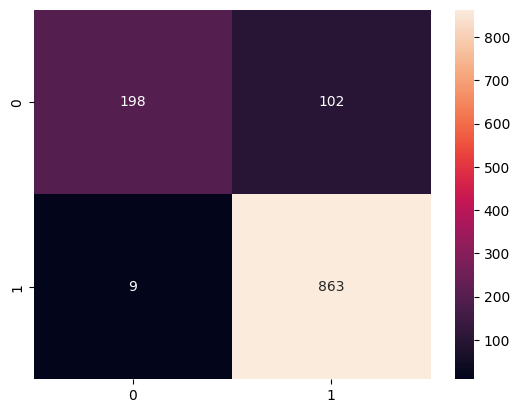

[[198 102]
 [  9 863]]
recall :  0.9896788990825688
precision :  0.894300518134715
f1score :  0.939575394665215


In [74]:
# Predict the probabilities
y_pred = model.predict(testx)

# Convert probabilities to class labels
y_pred_label = np.round(y_pred).astype(int)

# Create the confusion matrix
cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label)
precision = precision_score(testy, y_pred_label)
f1score = f1_score(testy, y_pred_label)
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

#### Tentative GridSearch

In [ ]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
print("testx normalized")
xval = xval / 255
print("xval normalized")

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

xtrain normalized


In [10]:
num_classes= 1
core_size = 4

def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(256, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=create_model, verbose=3)

print("model crée")

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

print("param grid défini")

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
print("fit va commencer")
grid_result = grid.fit(xtrain, ytrain)
print("fit done")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

model crée
param grid défini
fit va commencer


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


#### Validation curve core_size

In [14]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
xval = xval / 255

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

xtrain normalized
testx normalized
xval normalized


def create_model done
model defined
start validation_curve
79/79 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 0.4883 - recall: 0.9589
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 335ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.5837 - recall: 0.9241
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - loss: 0.8481 - recall: 0.9505
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - loss: 0.8949 - recall: 0.9971
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - loss: 0.8201 - recall: 0.9186
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - loss: 0.5219 - recall: 0.9098
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step
79/79 ━━━━━━━━━━━━━━━━━

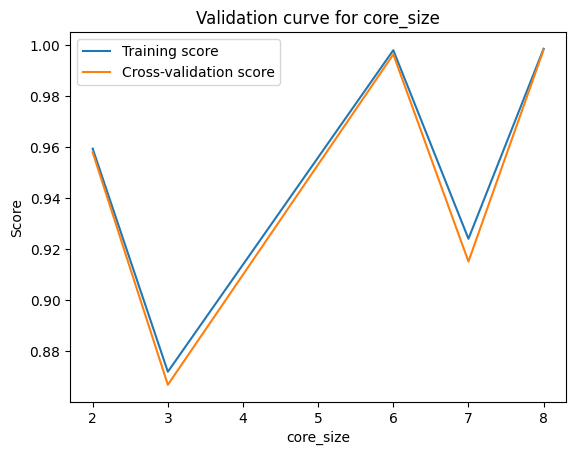

In [16]:
from sklearn.model_selection import validation_curve

# Define a function to create a model with a given core_size
def create_model(core_size):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(256, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['recall'])
    return model

print("def create_model done")

# Wrap the model in a KerasClassifier
model = KerasClassifier(model=create_model, verbose=1, core_size=2)

print("model defined")

# Define the range of core_sizes to evaluate
core_sizes = [2, 3, 6, 7, 8]

print("start validation_curve")
# Compute the validation curve
train_scores, valid_scores = validation_curve(
    model, xtrain, ytrain, param_name="core_size", param_range=core_sizes, cv=3, scoring="recall"
)
print("start validation_curve")

# Plot the validation curve
plt.figure()
plt.plot(core_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(core_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for core_size')
plt.xlabel('core_size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

#### Validation curve epoch

In [ ]:
import matplotlib.pyplot as plt

# Liste pour stocker les scores de validation
val_scores = []
core_size = 8

# Liste des nombres d'epochs à tester
epochs_list = [1, 2, 3, 4, 5]

for epochs in epochs_list:
    # Créer un nouveau modèle pour chaque itération
    model = create_model(core_size)

    # Entraîner le modèle avec le nombre actuel d'epochs
    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=epochs, verbose=1)

    # Obtenir le score de validation du dernier epoch et l'ajouter à la liste
    val_scores.append(history.history['val_loss'][-1])

# Tracer les scores de validation en fonction du nombre d'epochs
plt.plot(epochs_list, val_scores)
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Epochs')
plt.show()

In [ ]:
y_pred = model.predict(testx)
y_pred_label = np.round(y_pred).astype(int)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label)
precision = precision_score(testy, y_pred_label)
f1score = f1_score(testy, y_pred_label)
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

### Validation curve

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    validation_data=(xval, yval),
                    epochs=2)

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(12, 4))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(12, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()